# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter. 

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/drive/MyDrive/assignment3_starter/assignment3_part1"
if not os.path.exists(datadir):
  !ln -s "/content/drive/MyDrive/assignment3_starter/assignment3_part1" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

/content/drive/MyDrive/assignment3_starter/assignment3_part1


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
  if rot == 0: # 0 degrees rotation
      return img
  # TODO: Implement rotate_img() - return the rotated img
  elif rot == 1:
    transform = transforms.RandomRotation(degrees=(90,90))
    img = transform(img)
    return img
  elif rot == 2:
    transform = transforms.RandomRotation(degrees=(180,180))
    img = transform(img)
    return img
  elif rot == 3:
    transform = transforms.RandomRotation(degrees=(270,270))
    img = transform(img)
    return img
  else:
    
    raise ValueError('rotation should be 0, 90, 180, or 270 degrees')
    


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

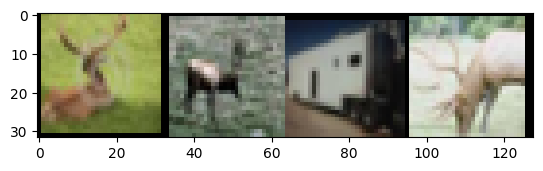

Class labels:  deer  deer  truck deer 


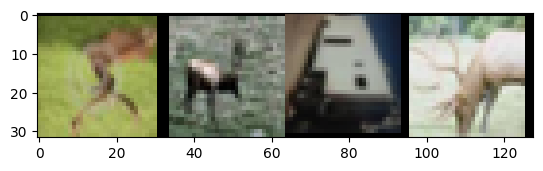

Rotation labels:  180   0     270   0    


In [ ]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

#Evaluation code

In [ ]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            #
            #
            #
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [ ]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer
#
#
#
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net = net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            #
            if task == 'rotation':
              imgs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              imgs, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            #
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            #
            #
            #
            #
            #
            optimizer.zero_grad()
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            predicted = None
            _, predicted = torch.max(outputs.data, 1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        #
        #
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
#

#PATH = 'res_net1.pth'
#torch.save(net.state_dict(), PATH)

[1,   100] loss: 0.730 acc: 70.62 time: 5.29
[1,   200] loss: 0.747 acc: 69.98 time: 5.09
[1,   300] loss: 0.745 acc: 70.32 time: 5.34
TESTING:
Accuracy of the network on the 10000 test images: 72.13 %
Average loss on the 10000 test images: 0.696
[2,   100] loss: 0.746 acc: 69.97 time: 5.26
[2,   200] loss: 0.736 acc: 70.54 time: 5.05
[2,   300] loss: 0.735 acc: 70.77 time: 5.12
TESTING:
Accuracy of the network on the 10000 test images: 71.68 %
Average loss on the 10000 test images: 0.703
[3,   100] loss: 0.741 acc: 70.47 time: 5.49
[3,   200] loss: 0.728 acc: 70.65 time: 5.28
[3,   300] loss: 0.718 acc: 71.43 time: 5.07
TESTING:
Accuracy of the network on the 10000 test images: 71.82 %
Average loss on the 10000 test images: 0.710
[4,   100] loss: 0.735 acc: 70.37 time: 5.40
[4,   200] loss: 0.712 acc: 71.35 time: 5.30
[4,   300] loss: 0.717 acc: 71.18 time: 5.22
TESTING:
Accuracy of the network on the 10000 test images: 72.62 %
Average loss on the 10000 test images: 0.686
[5,   100] l

In [ ]:
PATH = 'res_net1.pth'
torch.save(net.state_dict(), PATH)

##Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
#
#
net = resnet18(num_classes = 4)
net.load_state_dict(torch.load('res_net1.pth'))
net = net.to(device)



In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
#
#
#
#
net.fc = nn.Linear(512, 10)
net = net.to(device)
for name, para in net.named_parameters():
  para.requires_grad = False
  if "layer4" in name or "fc" in name:
    para.requires_grad = True
  

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
import torch.optim as optim
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>can only test a child process

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[1,   100] loss: 1.681 acc: 40.33 time: 9.12
[1,   200] loss: 1.336 acc: 51.71 time: 9.84
[1,   300] loss: 1.259 acc: 54.27 time: 9.50


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>    
self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in

TESTING:
Accuracy of the network on the 10000 test images: 59.55 %
Average loss on the 10000 test images: 1.135


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in 

[2,   100] loss: 1.190 acc: 57.25 time: 8.67
[2,   200] loss: 1.175 acc: 57.98 time: 9.96
[2,   300] loss: 1.168 acc: 58.47 time: 9.92


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in 

TESTING:
Accuracy of the network on the 10000 test images: 61.03 %
Average loss on the 10000 test images: 1.126


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():can only test a child process: self._shutdown_workers()

  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[3,   100] loss: 1.150 acc: 58.05 time: 8.82
[3,   200] loss: 1.104 acc: 60.80 time: 9.85
[3,   300] loss: 1.133 acc: 59.55 time: 9.85


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

TESTING:
Accuracy of the network on the 10000 test images: 62.31 %
Average loss on the 10000 test images: 1.064


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    

self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    self._shutdown_workers()
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
if w.is_alive():    
if w.is_alive():  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child

[4,   100] loss: 1.077 acc: 61.74 time: 9.42
[4,   200] loss: 1.078 acc: 61.78 time: 9.15
[4,   300] loss: 1.093 acc: 60.81 time: 9.84


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040><function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Traceback (most recent call last):

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
      File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():
      File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a c

TESTING:
Accuracy of the network on the 10000 test images: 62.26 %
Average loss on the 10000 test images: 1.102


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
self._shutdown_workers()    
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
if w.is_alive():    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a c

[5,   100] loss: 1.064 acc: 62.16 time: 10.09
[5,   200] loss: 1.054 acc: 62.12 time: 8.57
[5,   300] loss: 1.044 acc: 62.34 time: 9.83


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

TESTING:
Accuracy of the network on the 10000 test images: 63.61 %
Average loss on the 10000 test images: 1.024


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
if w.is_alive():
    self._shutdown_workers()  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionErrorif w.is_alive():: 
can only test a child process  File "/usr/lib/python

[6,   100] loss: 1.031 acc: 62.71 time: 10.35
[6,   200] loss: 1.028 acc: 63.45 time: 8.29
[6,   300] loss: 1.019 acc: 64.00 time: 9.77


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in 

TESTING:
Accuracy of the network on the 10000 test images: 62.69 %
Average loss on the 10000 test images: 1.089


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa5ae1ca040>    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionError: can only test a child process
if w.is_alive():
  File "/usr/lib/pytho

[7,   100] loss: 1.013 acc: 63.21 time: 10.29
[7,   200] loss: 1.019 acc: 63.79 time: 11.48
[7,   300] loss: 1.001 acc: 64.33 time: 8.17
TESTING:
Accuracy of the network on the 10000 test images: 63.64 %
Average loss on the 10000 test images: 1.042
[8,   100] loss: 0.973 acc: 65.35 time: 9.92
[8,   200] loss: 1.000 acc: 64.19 time: 9.94
[8,   300] loss: 0.982 acc: 64.81 time: 8.28
TESTING:
Accuracy of the network on the 10000 test images: 64.79 %
Average loss on the 10000 test images: 0.974
[9,   100] loss: 0.974 acc: 65.20 time: 10.09
[9,   200] loss: 0.986 acc: 64.81 time: 9.95
[9,   300] loss: 0.974 acc: 65.34 time: 8.35
TESTING:
Accuracy of the network on the 10000 test images: 65.01 %
Average loss on the 10000 test images: 0.980
[10,   100] loss: 0.934 acc: 66.53 time: 9.44
[10,   200] loss: 0.960 acc: 65.80 time: 9.80
[10,   300] loss: 0.971 acc: 65.45 time: 9.21
TESTING:
Accuracy of the network on the 10000 test images: 64.77 %
Average loss on the 10000 test images: 1.003
[11,  

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#
net2 = resnet18(weights=None)
net2 = net2.to(device)

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
#
#
#
for name, para in net2.named_parameters():
  para.requires_grad = False
  if "layer4" in name or "fc" in name:
    para.requires_grad = True

In [ ]:
# Print all the trainable parameters
params_to_update = net2.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net2.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
import torch.optim as optim
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(net2, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.319 acc: 24.15 time: 5.46
[1,   200] loss: 1.986 acc: 29.16 time: 5.23
[1,   300] loss: 1.936 acc: 30.54 time: 5.27
TESTING:
Accuracy of the network on the 10000 test images: 36.09 %
Average loss on the 10000 test images: 1.790
[2,   100] loss: 1.873 acc: 32.43 time: 5.27
[2,   200] loss: 1.874 acc: 32.20 time: 5.08
[2,   300] loss: 1.847 acc: 33.96 time: 5.22
TESTING:
Accuracy of the network on the 10000 test images: 37.80 %
Average loss on the 10000 test images: 1.732
[3,   100] loss: 1.820 acc: 33.97 time: 5.41
[3,   200] loss: 1.815 acc: 34.59 time: 5.31
[3,   300] loss: 1.808 acc: 34.38 time: 5.40
TESTING:
Accuracy of the network on the 10000 test images: 38.63 %
Average loss on the 10000 test images: 1.739
[4,   100] loss: 1.791 acc: 35.42 time: 5.41
[4,   200] loss: 1.798 acc: 35.48 time: 5.35
[4,   300] loss: 1.746 acc: 36.79 time: 5.34
TESTING:
Accuracy of the network on the 10000 test images: 39.32 %
Average loss on the 10000 test images: 1.689
[5,   100] l

##Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
#
#
#
net3 = resnet18(num_classes = 4)
net3.load_state_dict(torch.load('res_net1.pth'))
net3 = net3.to(device)
net3.fc = nn.Linear(512, 10)
net3 = net3.to(device)

In [ ]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net3.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(net3, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.509 acc: 45.37 time: 13.00
[1,   200] loss: 1.185 acc: 57.27 time: 5.04
[1,   300] loss: 1.092 acc: 61.03 time: 5.05
TESTING:
Accuracy of the network on the 10000 test images: 65.35 %
Average loss on the 10000 test images: 0.991
[2,   100] loss: 1.002 acc: 64.85 time: 5.26
[2,   200] loss: 0.979 acc: 65.18 time: 5.07
[2,   300] loss: 0.934 acc: 66.60 time: 5.09
TESTING:
Accuracy of the network on the 10000 test images: 69.23 %
Average loss on the 10000 test images: 0.873
[3,   100] loss: 0.875 acc: 68.97 time: 5.50
[3,   200] loss: 0.849 acc: 70.25 time: 5.05
[3,   300] loss: 0.849 acc: 70.46 time: 5.15
TESTING:
Accuracy of the network on the 10000 test images: 72.08 %
Average loss on the 10000 test images: 0.790
[4,   100] loss: 0.805 acc: 71.30 time: 5.28
[4,   200] loss: 0.793 acc: 72.09 time: 5.13
[4,   300] loss: 0.784 acc: 72.13 time: 5.16
TESTING:
Accuracy of the network on the 10000 test images: 74.18 %
Average loss on the 10000 test images: 0.739
[5,   100] 

##Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
#
#
#
net4 = resnet18(weights=None)
net4 = net4.to(device)

In [ ]:
import torch.optim as optim
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net4.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train(net4, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.216 acc: 27.08 time: 5.27
[1,   200] loss: 1.675 acc: 38.63 time: 5.07
[1,   300] loss: 1.555 acc: 43.10 time: 5.06
TESTING:
Accuracy of the network on the 10000 test images: 50.98 %
Average loss on the 10000 test images: 1.347
[2,   100] loss: 1.400 acc: 49.37 time: 5.21
[2,   200] loss: 1.385 acc: 49.88 time: 5.48
[2,   300] loss: 1.335 acc: 51.55 time: 5.09
TESTING:
Accuracy of the network on the 10000 test images: 55.28 %
Average loss on the 10000 test images: 1.251
[3,   100] loss: 1.260 acc: 55.61 time: 5.38
[3,   200] loss: 1.200 acc: 57.02 time: 5.15
[3,   300] loss: 1.173 acc: 58.16 time: 5.15
TESTING:
Accuracy of the network on the 10000 test images: 61.98 %
Average loss on the 10000 test images: 1.083
[4,   100] loss: 1.079 acc: 61.37 time: 5.36
[4,   200] loss: 1.088 acc: 61.61 time: 5.15
[4,   300] loss: 1.050 acc: 63.26 time: 5.08
TESTING:
Accuracy of the network on the 10000 test images: 64.68 %
Average loss on the 10000 test images: 1.035
[5,   100] l